# Time Series

- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [4]:
!pip install tbats

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle
from tbats import TBATS, BATS

In [2]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
input_prefix = 'data/'
#input_prefix = 'https://github.com/hjort/ai-labs/raw/master/jupyter/sales-russia/data/'

bzfile = '.bz2' # ''

In [5]:
df_train = pd.read_csv(
    input_prefix + '../sales_monthly.csv' + bzfile, #nrows=10000,
    #input_prefix + '../sales_monthly_full.csv' + bzfile, #nrows=10000,
    #input_prefix + '../train_full.csv' + bzfile, #nrows=10000,
    dtype={'date_block_num': np.int8, 'shop_id': np.int8, 'item_id': np.int16,
           'item_price_mean': np.int32, 'item_cnt_sum': np.int32,
           'city_code': 'category', 'item_category_id': 'category',
           'subject_code': 'category', 'group_code': 'category', 'subgroup_code': 'category'},
    index_col=['shop_id', 'item_id', 'date_block_num']
)
print('shape:', df_train.shape)
df_train.head()

shape: (1608226, 2)


/dados/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [6]:
data = df_train.copy()
#data = df_train.drop(columns=['city_code', 'item_category_id', 'subject_code', 'group_code', 'subgroup_code'])

In [7]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [8]:
data = data.query('(shop_id == 5) & (item_id == 5037)')
#data = data.query('(shop_id == 28) & (item_id == 20949)')
#data = data.query('(shop_id == 31) & (item_id == 20949)')
#data = data.query('(shop_id == 55) & (item_id == 492)')

In [9]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
5       5037    20                         2599             1
                22                         2599             1
                23                         1999             2
                24                         1999             2
                28                         1299             1

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, (5, 5037, 20) to (5, 5037, 32)
Data columns (total 2 columns):
item_price_mean    9 non-null int32
item_cnt_sum       9 non-null int32
dtypes: int32(2)
memory usage: 171.4 KB


In [11]:
data = data.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1


In [12]:
data = pd.merge(pd.DataFrame({'date_block_num': np.arange(data.index.min(), 34)}).set_index('date_block_num'),
         data, how='left', left_index=True, right_index=True)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599.0,1.0
21,NaN,NaN
22,2599.0,1.0
23,1999.0,2.0
24,1999.0,2.0


In [13]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499.0,1.0
30,1499.0,1.0
31,1000.0,3.0
32,750.0,1.0
33,NaN,NaN


In [14]:
data['item_cnt_sum'] = data['item_cnt_sum'].fillna(0).astype(np.int32)
data['item_price_mean'] = data['item_price_mean'].fillna(method='bfill').fillna(method='ffill').astype(np.int32)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
21,2599,0
22,2599,1
23,1999,2
24,1999,2


In [15]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499,1
30,1499,1
31,1000,3
32,750,1
33,750,0


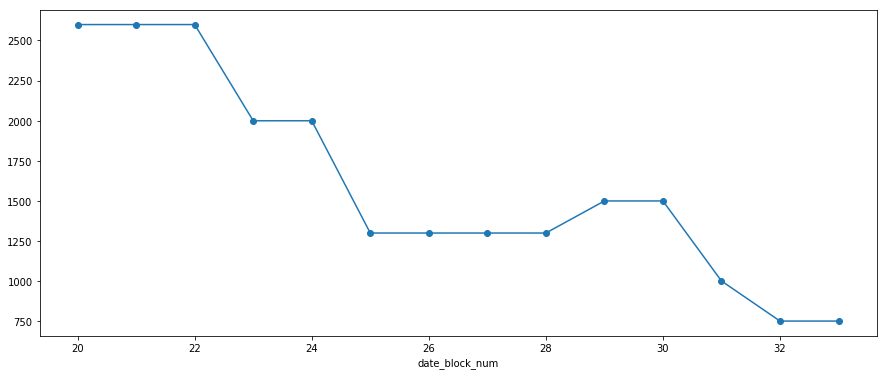

In [16]:
data['item_price_mean'].plot(marker='o')

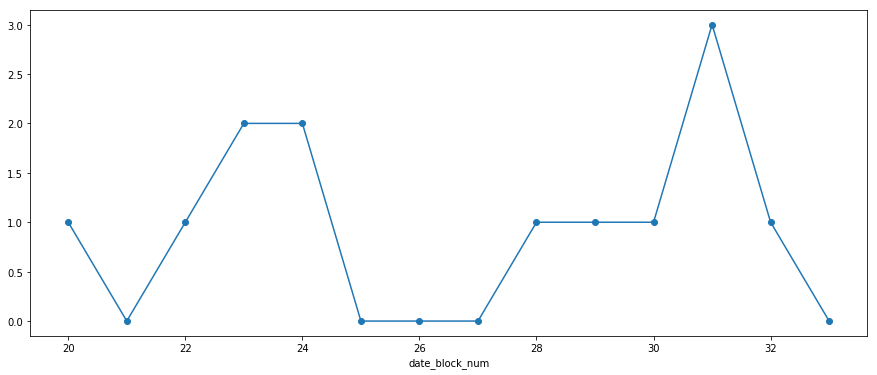

In [17]:
data['item_cnt_sum'].plot(marker='o')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27db056358>,
      dtype=object)

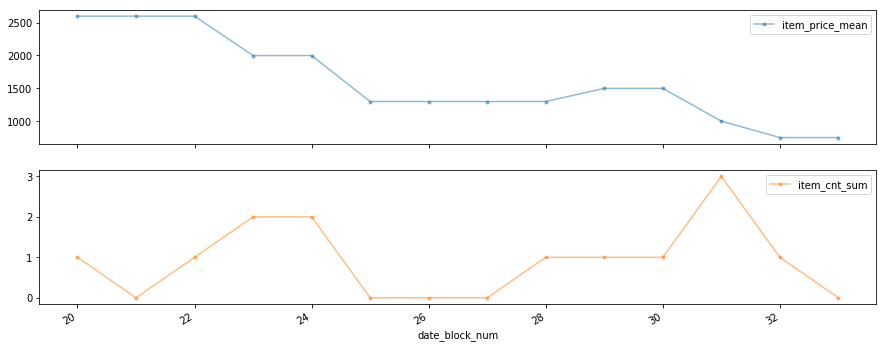

In [18]:
data.plot(marker='.', alpha=0.5, subplots=True)

# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

In [19]:
y = data['item_cnt_sum']

tamanho = len(y)
corte = int(np.ceil(tamanho * 0.75))
resto = tamanho - corte
print('Tamanho: %-3d\nCorte:   %-3d\nResto:    %-3d' % (tamanho, corte, resto))

y_train = y.iloc[:corte]
y_test = y.iloc[corte:]

Tamanho: 14 
Corte:   11 
Resto:    3  


In [20]:
y_train[:5]

date_block_num
20    1
21    0
22    1
23    2
24    2
Name: item_cnt_sum, dtype: int32

In [21]:
y_test[-5:]

date_block_num
31    3
32    1
33    0
Name: item_cnt_sum, dtype: int32

In [22]:
# Fit the model
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)
%time model = estimator.fit(y_train)

CPU times: user 375 ms, sys: 75.6 ms, total: 451 ms
Wall time: 2.66 s


In [23]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=resto)
print(y_forecast)

y_forecast = y_forecast.round().astype(np.int32)
y_forecast

[ 3.00000000e+00  1.00000000e+00 -5.55111512e-16]


array([3, 1, 0], dtype=int32)

In [25]:
y_true = y[-resto:].values
y_true

array([3, 1, 0], dtype=int32)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('MSE:', mean_squared_error(y_true, y_forecast))
print('MAE:', mean_absolute_error(y_true, y_forecast))
print('R²:', r2_score(y_true, y_forecast))

MSE: 0.0
MAE: 0.0
R²: 1.0


In [27]:
%time model = estimator.fit(y)

CPU times: user 442 ms, sys: 84 ms, total: 526 ms
Wall time: 2.44 s


In [28]:
y_pred = model.forecast(steps=3)
y_pred = y_pred.round().clip(0, 20).astype(np.int32)
y_pred

array([1, 2, 2], dtype=int32)

In [6]:
df_test = pd.read_csv(
    input_prefix + 'test.csv' + bzfile, #nrows=10000,
    dtype={'shop_id': np.int8, 'item_id': np.int16},
    index_col='ID')
print('shape:', df_test.shape)
df_test.head()

shape: (214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [36]:
#!rm -f prediction.csv && touch prediction.csv

In [7]:
filename = 'prediction.csv'
last_id = None

with open(filename) as infile:
  empty = (infile.read(1) == '')
  if (not empty):
    last_line = list(infile)[-1]
    last_id = int(last_line.split(',')[0])
infile.close()

outfile = open(filename, "a+", buffering=100)
if (empty):
  outfile.write('ID,item_cnt_month\n')
  print('File does not exist. Creating one.')
else:
  print('File already exists. Resuming from ID #%d' % last_id)

#for i in range(0, 10):
#  outfile.write("%d,%.1f\n" % (i, i%7))
#outfile.close()

File already exists. Resuming from ID #60980


In [8]:
!tail prediction.csv

60971,0.0
60972,0.0
60973,0.0
60974,1.0
60975,0.0
60976,0.0
60977,1.0
60978,0.0
60979,1.0
60980,1.0


In [ ]:
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)

for index, row in df_test.iterrows():
#for index, row in df_test.head(10).iterrows():
    if (last_id and index <= last_id):
      continue

    shop_id = row['shop_id']
    item_id = row['item_id']
    #print(index, shop_id, item_id)

    #df_sale = df_train.loc[shop_id, item_id][['item_cnt_sum']]
    df_sale = df_train.query('(shop_id == %d) & (item_id == %d)' % (shop_id, item_id))[['item_cnt_sum']]
    if (not df_sale.empty):

      df_sale = df_sale.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
      df_sale = pd.merge(
        pd.DataFrame({'date_block_num': np.arange(df_sale.index.min(), 34)}).set_index('date_block_num'),
        df_sale, how='left', left_index=True, right_index=True)
      df_sale['item_cnt_sum'] = df_sale['item_cnt_sum'].fillna(0).astype(np.int32)
      #df_sale['item_price_mean'] = df_sale['item_price_mean'].fillna(
      #  method='bfill').fillna(method='ffill').astype(np.int32)

      if (df_sale.shape[0] >= 4):
          model = estimator.fit(df_sale['item_cnt_sum'])
          y_pred = model.forecast(steps=1)
          y_pred = y_pred[0].round().clip(0, 20)
          #y_pred = y_pred[0].round().clip(0, 20).astype(np.int32)
      else:
          y_pred = 0
    else:
      y_pred = 0
    
    outfile.write("%d,%.1f\n" % (index, y_pred))

    if (index % 10 == 0):
      outfile.flush()
      print(index, shop_id, item_id, y_pred)

outfile.close()

60990 25 16231 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61000 25 17015 0
61010 25 13133 0.0
61020 25 14222 1.0
61030 25 13812 1.0
61040 25 5010 0.0
61050 25 21210 0
61060 25 20916 4.0
61070 25 21664 0
61080 25 3232 0
61090 25 3547 1.0
61100 25 18707 0
61110 25 11674 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61120 25 16057 7.0
61130 25 15033 0
61140 25 10508 0.0
61150 25 7572 0
61160 25 6882 0.0
61170 25 14543 0
61180 25 19889 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61190 25 3280 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61200 22 5037 0.0
61210 22 4806 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61220 22 4717 0.0
61230 22 5666 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61240 22 5840 0
61250 22 5838 0
61260 22 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61270 22 3604 0
61280 22 3443 5.0
61290 22 4365 0
61300 22 3733 0.0
61310 22 4052 0.0
61320 22 9395 0.0
61330 22 9469 0
61340 22 8653 0
61350 22 9001 1.0
61360 22 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61370 22 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61380 22 9927 0
61390 22 6506 0
61400 22 6731 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61410 22 6396 0.0
61420 22 6064 6.0
61430 22 7862 0
61440 22 7328 2.0
61450 22 7029 0
61460 22 15777 0.0
61470 22 16843 5.0
61480 22 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61490 22 16103 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61500 22 18825 0.0
61510 22 19656 0
61520 22 18397 0
61530 22 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61540 22 13023 0.0
61550 22 13415 0
61560 22 13464 0
61570 22 14832 0
61580 22 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61590 22 15037 0
61600 22 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61610 22 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61620 22 2574 0.0
61630 22 3076 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61640 22 2779 1.0
61650 22 2873 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61660 22 20949 20.0
61670 22 21937 0
61680 22 20400 0
61690 22 20616 0
61700 22 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61710 22 982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61720 22 1486 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61730 22 2328 0
61740 22 2293 0.0
61750 22 3022 0
61760 22 2743 1.0
61770 22 1963 0
61780 22 1295 0
61790 22 22100 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61800 22 482 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61810 22 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61820 22 1570 0.0
61830 22 4003 3.0
61840 22 3851 0.0
61850 22 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61860 22 4085 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61870 22 3528 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61880 22 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61890 22 12771 1.0
61900 22 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61910 22 15047 0.0
61920 22 13818 0
61930 22 12549 0.0
61940 22 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61950 22 12360 5.0
61960 22 11811 1.0
61970 22 12023 0
61980 22 13275 0
61990 22 13303 0
62000 22 13226 0
62010 22 20609 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62020 22 19430 0.0
62030 22 21942 0
62040 22 18201 0
62050 22 16122 0.0
62060 22 14668 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62070 22 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62080 22 17481 0.0
62090 22 16541 0.0
62100 22 1239 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62110 22 20631 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62120 22 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62130 22 15282 0
62140 22 16145 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62150 22 19125 0
62160 22 17032 0
62170 22 5383 0
62180 22 4895 0.0
62190 22 6505 0
62200 22 6082 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62210 22 3822 3.0
62220 22 6129 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62230 22 3833 0.0
62240 22 3871 0.0
62250 22 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62260 22 11938 0.0
62270 22 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62280 22 7982 0.0
62290 22 7224 0
62300 22 10211 0.0
62310 22 9404 1.0
62320 22 4049 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62330 22 4999 0.0
62340 22 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62350 22 10190 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62360 22 9408 0.0
62370 22 13237 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62380 22 10987 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62390 22 6625 1.0
62400 22 6090 0.0
62410 22 7019 0.0
62420 22 12500 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62430 22 10448 0
62440 22 12805 0.0
62450 22 14247 0
62460 22 7133 0
62470 22 10292 1.0
62480 22 1007 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62490 22 1717 0.0
62500 22 14390 0.0
62510 22 19908 0.0
62520 22 17888 0
62530 22 21722 0
62540 22 940 0
62550 22 18926 0.0
62560 22 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62570 22 19219 0
62580 22 20225 0.0
62590 22 5816 1.0
62600 22 8868 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62610 22 17459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62620 22 17420 0.0
62630 22 10812 0
62640 22 11771 0
62650 22 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62660 22 10378 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62670 22 16125 0.0
62680 22 15300 1.0
62690 22 17270 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62700 22 16735 0.0
62710 22 13893 0
62720 22 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62730 22 14267 0.0
62740 22 7592 0
62750 22 8734 0
62760 22 8986 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62770 22 8453 0
62780 22 4141 0
62790 22 6420 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62800 22 11266 0.0
62810 22 13270 0
62820 22 13100 3.0
62830 22 10146 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62840 22 10425 0
62850 22 11365 0
62860 22 14848 0
62870 22 21367 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62880 22 8077 0.0
62890 22 12286 0
62900 22 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62910 22 3862 2.0
62920 22 794 0
62930 22 353 0
62940 22 1074 0
62950 22 13208 0
62960 22 12501 2.0
62970 22 10045 0
62980 22 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62990 22 11534 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63000 22 15512 0
63010 22 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63020 22 16534 0.0
63030 22 16155 1.0
63040 22 12830 0.0
63050 22 14124 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63060 22 5945 0.0
63070 22 6678 0
63080 22 4944 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63090 22 5517 0
63100 22 8398 0
63110 22 7458 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63120 22 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63130 22 7793 1.0
63140 22 3477 0
63150 22 8686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63160 22 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63170 22 19874 0
63180 22 17869 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63190 22 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63200 22 18255 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63210 22 2639 0.0
63220 22 21827 0.0
63230 22 1238 0
63240 22 1247 0.0
63250 22 269 1.0
63260 22 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63270 22 93 0.0
63280 22 20718 0
63290 22 42 0.0
63300 22 21842 0.0
63310 22 2324 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63320 22 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63330 22 3080 0
63340 22 2886 0
63350 22 13587 0
63360 22 13691 0
63370 22 15169 0
63380 22 14973 0
63390 22 13113 0
63400 22 11711 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63410 22 13231 0
63420 22 18677 2.0
63430 22 18686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63440 22 20374 0.0
63450 22 20571 0
63460 22 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63470 22 16036 0
63480 22 15276 0.0
63490 22 16177 0
63500 22 8687 0
63510 22 9171 0.0
63520 22 9366 0
63530 22 7459 0
63540 22 8148 0
63550 22 8510 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63560 22 9449 0.0
63570 22 10786 0.0
63580 22 10669 0.0
63590 22 11379 0.0
63600 22 11542 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63610 22 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63620 22 9539 0.0
63630 22 10325 0.0
63640 22 9840 0
63650 22 10003 0.0
63660 22 4708 3.0
63670 22 4604 0.0
63680 22 5323 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63690 22 3897 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63700 22 3919 0
63710 22 3787 1.0
63720 22 4088 0
63730 22 6695 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63740 22 6378 1.0
63750 22 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63760 22 5659 0.0
63770 22 3354 0
63780 22 1538 0
63790 22 22111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63800 22 9019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63810 22 11968 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63820 22 6027 0.0
63830 22 18361 0.0
63840 22 18629 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63850 22 17883 0
63860 22 18108 0
63870 22 19126 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63880 22 19488 0
63890 22 18759 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63900 22 18979 0
63910 22 3236 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63920 22 19588 1.0
63930 22 20952 0
63940 22 21207 0
63950 22 20833 0
63960 22 20274 0.0
63970 22 21795 0
63980 22 21792 0.0
63990 22 19951 0
64000 22 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64010 22 20600 0
64020 22 20581 0
64030 22 6312 0
64040 22 3634 0
64050 22 4707 0
64060 22 8888 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64070 22 10099 0
64080 22 6807 0
64090 22 8112 0.0
64100 22 19118 14.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64110 22 21790 0.0
64120 22 13630 0
64130 22 15478 0
64140 22 15226 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64150 22 2585 0.0
64160 22 2213 0
64170 22 1611 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64180 22 12504 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64190 22 13445 0
64200 22 11915 0.0
64210 22 20739 1.0
64220 22 21196 0
64230 22 14108 0.0
64240 22 3457 0
64250 22 3096 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64260 22 15260 0.0
64270 22 17157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64280 22 413 0.0
64290 22 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64300 22 4364 0.0
64310 22 6528 0
64320 22 5470 0
64330 22 19337 1.0
64340 22 18017 0.0
64350 22 14892 1.0
64360 22 20393 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64370 22 15171 0
64380 22 16093 0
64390 22 16111 0
64400 22 14962 0
64410 22 16207 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64420 22 16786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64430 22 8157 0
64440 22 13448 0
64450 22 13224 0
64460 22 13512 0.0
64470 22 13288 0
64480 22 14164 0.0
64490 22 12808 0.0
64500 22 13647 0
64510 22 12332 0
64520 22 12091 0.0
64530 22 11268 0
64540 22 13223 0
64550 22 13221 0
64560 22 16179 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64570 22 15524 0
64580 22 16045 0
64590 22 16910 0
64600 22 15667 0
64610 22 16243 0
64620 22 16349 0
64630 22 15015 0.0
64640 22 15134 0.0
64650 22 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64660 22 15318 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64670 22 15168 0
64680 22 15220 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64690 22 6870 0
64700 22 4480 0
64710 22 5063 0.0
64720 22 5155 0
64730 22 5187 0
64740 22 5121 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64750 22 10069 0
64760 22 10287 0.0
64770 22 10180 0.0
64780 22 10772 0.0
64790 22 11363 0.0
64800 22 11044 0
64810 22 8459 0.0
64820 22 8363 0
64830 22 7580 0
64840 22 8968 0
64850 22 9338 0
64860 22 8428 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64870 22 14361 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64880 22 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64890 22 12743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64900 22 20517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64910 22 7924 0.0
64920 22 3239 0.0
64930 22 15458 0.0
64940 22 18025 0
64950 22 15031 10.0
64960 22 14984 0
64970 22 1254 0
64980 22 18968 0
64990 22 21139 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65000 22 3273 0
65010 22 13407 0
65020 22 21692 0
65030 22 19127 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65040 22 16953 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65050 22 21400 2.0
65060 22 20334 0
65070 22 13693 0
65080 22 12474 0
65090 22 8468 0
65100 22 11302 0
65110 22 448 0.0
65120 22 5272 0.0
65130 22 6028 0.0
65140 22 8855 0.0
65150 22 2540 0
65160 22 18315 0.0
65170 22 2191 0.0
65180 22 3333 0.0
65190 22 20879 0
65200 22 14760 0
65210 22 4637 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65220 22 13494 1.0
65230 22 16032 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65240 22 2523 0
65250 22 5540 0.0
65260 22 1453 1.0
65270 22 11011 0
65280 22 3548 0
65290 22 6307 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65300 22 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65310 22 19751 0.0
65320 22 18457 0
65330 22 18208 0.0
65340 22 22013 0.0
65350 22 20653 0.0
65360 22 21053 0
65370 22 11516 0.0
65380 22 18481 0.0
65390 22 15222 0
65400 22 13327 0
65410 22 18031 0
65420 22 20821 0
65430 22 18939 1.0
65440 22 12208 0.0
65450 22 15654 0
65460 22 16028 0.0
65470 22 20516 0
65480 22 6400 0
65490 22 16166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65500 22 9534 0
65510 22 10581 0
65520 22 9111 0
65530 22 13099 0
65540 22 11874 0
65550 22 12192 0
65560 22 6430 0
65570 22 5761 0
65580 22 4903 0
65590 22 5382 0
65600 22 7817 0
65610 22 6959 0
65620 22 7057 0
65630 22 21978 0
65640 22 19347 0
65650 22 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65660 22 13732 0
65670 22 14934 0
65680 22 13341 0
65690 22 16396 0
65700 22 16813 0
65710 22 15988 0
65720 22 16272 0
65730 22 504 0
65740 22 688 0
65750 22 616 0
65760 22 204 0
65770 22 1394 0
65780 22 924 0
65790 22 1506 0
65800 22 849 0
65810 22 20361 1.0
65820 22 3715 0
65830 22 3411 0
65840 22 4765 0
65850 22 4260 0
65860 22 4144 0
65870 22 4203 0
65880 22 1794 0
65890 22 2338 0
65900 22 1792 0
65910 22 2856 0
65920 22 2434 0
65930 22 3136 0
65940 22 1018 0.0
65950 22 19258 0.0
65960 22 4736 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65970 22 5363 0.0
65980 22 17390 1.0
65990 22 11682 0.0
66000 22 15735 0
66010 22 14899 0.0
66020 22 20212 0.0
66030 22 5899 0.0
66040 22 18476 0.0
66050 22 6835 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66060 22 15405 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66070 22 17756 0.0
66080 22 18500 1.0
66090 22 16231 0
66100 22 17015 0.0
66110 22 13133 0.0
66120 22 14222 0.0
66130 22 13812 0.0
66140 22 5010 2.0
66150 22 21210 0
66160 22 20916 0
66170 22 21664 0
66180 22 3232 0
66190 22 3547 0
66200 22 18707 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66210 22 11674 0
66220 22 16057 0.0
66230 22 15033 0
66240 22 10508 0
66250 22 7572 0
66260 22 6882 0
66270 22 14543 0
66280 22 19889 0
66290 22 3280 0.0
66300 24 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66310 24 4806 10.0
66320 24 4717 0.0
66330 24 5666 3.0
66340 24 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66350 24 5838 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66360 24 3352 0
66370 24 3604 0
66380 24 3443 0.0
66390 24 4365 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66400 24 3733 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66410 24 4052 5.0
66420 24 9395 0
66430 24 9469 0
66440 24 8653 0.0
66450 24 9001 0.0
66460 24 10447 0
66470 24 10327 0
66480 24 9927 0
66490 24 6506 0
66500 24 6731 0
66510 24 6396 0
66520 24 6064 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66530 24 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66540 24 7328 0.0
66550 24 7029 0
66560 24 15777 0.0
66570 24 16843 0
66580 24 15496 0
66590 24 16103 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66600 24 18825 0.0
66610 24 19656 0
66620 24 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66630 24 15338 0
66640 24 13023 1.0
66650 24 13415 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66660 24 13464 4.0
66670 24 14832 0
66680 24 15069 0
66690 24 15037 0
66700 24 2131 0
66710 24 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66720 24 2574 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66730 24 3076 2.0
66740 24 2779 0.0
66750 24 2873 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66760 24 20949 20.0
66770 24 21937 0
66780 24 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66790 24 20616 0.0
66800 24 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66810 24 982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66820 24 1486 2.0
66830 24 2328 0
66840 24 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66850 24 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66860 24 2743 0.0
66870 24 1963 0
66880 24 1295 0
66890 24 22100 1.0
66900 24 482 5.0
66910 24 1877 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66920 24 1570 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66930 24 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66940 24 3851 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66950 24 4420 0.0
66960 24 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66970 24 3528 1.0
66980 24 3459 0
66990 24 12771 0.0
67000 24 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67010 24 15047 0
67020 24 13818 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67030 24 12549 0.0
67040 24 12698 0
67050 24 12360 0.0
67060 24 11811 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67070 24 12023 0
67080 24 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67090 24 13303 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67100 24 13226 0
67110 24 20609 0.0
67120 24 19430 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67130 24 21942 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67140 24 18201 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67150 24 16122 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67160 24 14668 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67170 24 15323 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67180 24 17481 0.0
67190 24 16541 0.0
67200 24 1239 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67210 24 20631 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67220 24 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67230 24 15282 2.0
67240 24 16145 0
67250 24 19125 0
67260 24 17032 0
67270 24 5383 0
67280 24 4895 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67290 24 6505 0
67300 24 6082 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67310 24 3822 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67320 24 6129 0
67330 24 3833 2.0
67340 24 3871 0.0
67350 24 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67360 24 11938 0.0
67370 24 14457 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67380 24 7982 4.0
67390 24 7224 0
67400 24 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67410 24 9404 2.0
67420 24 4049 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67430 24 4999 0
67440 24 3342 0.0
67450 24 10190 0
67460 24 9408 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67470 24 13237 0
67480 24 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67490 24 6625 0.0
67500 24 6090 1.0
67510 24 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67520 24 12500 0.0
67530 24 10448 0
67540 24 12805 0.0
67550 24 14247 0.0
67560 24 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67570 24 10292 0.0
67580 24 1007 0.0
67590 24 1717 1.0
67600 24 14390 0.0
67610 24 19908 2.0
67620 24 17888 0
67630 24 21722 0
67640 24 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67650 24 18926 0
67660 24 17772 0
67670 24 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67680 24 20225 0.0
67690 24 5816 0.0
67700 24 8868 0
67710 24 17459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67720 24 17420 0.0
67730 24 10812 0
67740 24 11771 0
67750 24 10554 0
67760 24 10378 1.0
67770 24 16125 0
67780 24 15300 0.0
67790 24 17270 0.0
67800 24 16735 0.0
67810 24 13893 0.0
67820 24 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67830 24 14267 0.0
67840 24 7592 0
67850 24 8734 2.0
67860 24 8986 0.0
67870 24 8453 0
67880 24 4141 0
67890 24 6420 0
67900 24 11266 0
67910 24 13270 0
67920 24 13100 0.0
67930 24 10146 0
67940 24 10425 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67950 24 11365 0
67960 24 14848 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67970 24 21367 1.0
67980 24 8077 0.0
67990 24 12286 1.0
68000 24 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68010 24 3862 0.0
68020 24 794 0
68030 24 353 0
68040 24 1074 0
68050 24 13208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68060 24 12501 0.0
68070 24 10045 0
68080 24 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68090 24 11534 0
68100 24 15512 0
68110 24 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68120 24 16534 0.0
68130 24 16155 0
68140 24 12830 1.0
68150 24 14124 0.0
68160 24 5945 0.0
68170 24 6678 0
68180 24 4944 1.0
68190 24 5517 0
68200 24 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68210 24 7458 3.0
68220 24 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68230 24 7793 1.0
68240 24 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68250 24 8686 0.0
68260 24 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68270 24 19874 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68280 24 17869 0.0
68290 24 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68300 24 18255 0.0
68310 24 2639 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68320 24 21827 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68330 24 1238 0
68340 24 1247 0.0
68350 24 269 0
68360 24 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68370 24 93 0.0
68380 24 20718 0
68390 24 42 0.0
68400 24 21842 0.0
68410 24 2324 0
68420 24 1663 0
68430 24 3080 0
68440 24 2886 0
68450 24 13587 0
68460 24 13691 0
68470 24 15169 0
68480 24 14973 0
68490 24 13113 0
68500 24 11711 0.0
68510 24 13231 0
68520 24 18677 0.0
68530 24 18686 0
68540 24 20374 0
68550 24 20571 0
68560 24 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68570 24 16036 0
68580 24 15276 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68590 24 16177 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68600 24 8687 0.0
68610 24 9171 0.0
68620 24 9366 0
68630 24 7459 0.0
68640 24 8148 0
68650 24 8510 0
68660 24 9449 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68670 24 10786 0.0
68680 24 10669 0
68690 24 11379 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68700 24 11542 0
68710 24 10893 0
68720 24 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68730 24 10325 0.0
68740 24 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68750 24 10003 0
68760 24 4708 0
68770 24 4604 2.0
68780 24 5323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68790 24 3897 0.0
68800 24 3919 0
68810 24 3787 0.0
68820 24 4088 0
68830 24 6695 1.0
68840 24 6378 0.0
68850 24 6857 1.0
68860 24 5659 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68870 24 3354 0
68880 24 1538 0
68890 24 22111 0.0
68900 24 9019 0.0
68910 24 11968 1.0
68920 24 6027 1.0
68930 24 18361 0.0
68940 24 18629 0
68950 24 17883 0
68960 24 18108 0
68970 24 19126 0.0
68980 24 19488 0
68990 24 18759 0
69000 24 18979 0
69010 24 3236 0.0
69020 24 19588 0.0
69030 24 20952 0
69040 24 21207 0
69050 24 20833 0
69060 24 20274 0
69070 24 21795 0
69080 24 21792 0
69090 24 19951 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69100 24 19852 0
69110 24 20600 0
69120 24 20581 0
69130 24 6312 0
69140 24 3634 0.0
69150 24 4707 0
69160 24 8888 0.0


In [37]:
df_train.query('(shop_id == %d) & (item_id == %d)' % (6, 5003))[['item_cnt_sum']] #10209 6 5003

item_cnt_sum
shop_id item_id date_block_num              
6       5003    32                         2
                33                         3

In [164]:
df_train.loc[5, 5037]

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1
29,1499,1
30,1499,1
31,1000,3
32,750,1


In [0]:
ids = df_test.index
ids

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', name='ID', length=214200)

In [0]:
X_pred = df_test.copy().reset_index().drop(columns=['ID'])
X_pred.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
df_shops = pd.read_csv(
    input_prefix + '../shops_full' + '.csv' + bzfile,
    dtype={'city_code': 'category'},
    index_col='shop_id')
print('shape:', df_shops.shape)
df_shops.drop(columns=['shop_name', 'city_name'], inplace=True)
df_shops.head()

shape: (60, 3)


,city_code
shop_id,
0,1
1,1
2,2
3,3
4,4


In [0]:
df_items = pd.read_csv(
    input_prefix + '../items_full' + '.csv' + bzfile,
    dtype={'item_category_id': 'category', 'subject_code': 'category',
           'group_code': 'category', 'subgroup_code': 'category'},
    index_col='item_id')
print('shape:', df_items.shape)
df_items.drop(columns=['item_name', 'subject_name', 'item_category_name', 'group_name', 'subgroup_name'], inplace=True)
df_items.head()

shape: (22170, 9)


,item_category_id,subject_code,group_code,subgroup_code
item_id,,,,
0,40,1803,11,8
1,76,111,15,31
2,40,1614,11,8
3,40,1958,11,8
4,40,2630,11,8


In [0]:
X_pred['date_block_num'] = 34
X_pred['item_price_mean'] = 0
X_pred.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
X_pred.head()

item_price_mean
shop_id item_id date_block_num                 
5       5037    34                            0
        5320    34                            0
        5233    34                            0
        5232    34                            0
        5268    34                            0

In [0]:
X_pred = X_pred.join(df_shops).join(df_items)
X_pred.head()

item_price_mean city_code item_category_id  \
shop_id item_id date_block_num                                               
5       5037    34                            0         5               19   
        5320    34                            0         5               55   
        5233    34                            0         5               19   
        5232    34                            0         5               23   
        5268    34                            0         5               20   

                               subject_code group_code subgroup_code  
shop_id item_id date_block_num                                        
5       5037    34                      793          6            13  
        5320    34                      818         13             6  
        5233    34                      786          6            13  
        5232    34                      786          6            19  
        5268    34                      786          6            14

In [0]:
y_pred = model.predict(X_pred)
y_pred[:30]

array([ 1.88292211,  2.03189192,  1.88292211,  1.85285458,  2.18216991,
        1.85285458,  2.18216991,  2.03189192,  2.03189192,  2.18216991,
        2.06270293,  2.18216991,  2.03189192,  1.85285458,  1.85285458,
        1.88292211, 11.78756569,  2.03189192,  2.06270293,  2.18216991,
        2.03189192,  1.88292211,  2.24096826,  1.88292211,  2.06270293,
        2.18216991,  1.85285458,  2.11946414,  2.34529601,  2.34529601])

In [0]:
#y_pred = np.clip(y_pred, 0, 20)
#y_pred = np.clip(np.round(y_pred), 0, 20)
y_pred = np.clip(np.floor(y_pred), 0, 20)
y_pred[:30]

array([ 1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1., 11.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.])

In [0]:
df_final = pd.DataFrame(data=y_pred, columns=['item_cnt_month'], index=ids)
df_final.index.names = ['ID']
df_final.head()

,item_cnt_month
ID,
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
item_cnt_month    214200 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


In [0]:
df_final.describe()

,item_cnt_month
count,214200.0000
mean,5.0916
std,6.0712
min,0.0000
25%,1.0000
50%,3.0000
75%,5.0000
max,20.0000


In [0]:
df_final.to_csv('submission6.csv')